In [2]:
import numpy as np
import pandas as pd
import keras
import cv2 as cv
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
import cv2    
from sklearn.metrics import confusion_matrix
import os

In [3]:
train_path = 'C:/Users/amitg/Portfolio_Projects/Areca_Nut_Disease_Prediction/Arecanut_dataset/train'
test_path = 'C:/Users/amitg/Portfolio_Projects/Areca_Nut_Disease_Prediction/Arecanut_dataset/test'

print("type of Images in Train dataset"+str(os.listdir(train_path)))
print("type of Images in Test dataset"+str(os.listdir(test_path)))

type of Images in Train dataset['bud borer', 'healthy_foot', 'Healthy_Leaf', 'Healthy_Nut', 'Healthy_Trunk', 'Mahali_Koleroga', 'stem cracking', 'Stem_bleeding', 'yellow leaf disease']
type of Images in Test dataset['bud borer', 'healthy_foot', 'Healthy_Leaf', 'Healthy_Nut', 'Healthy_Trunk', 'Mahali_Koleroga', 'stem cracking', 'Stem_bleeding', 'yellow leaf disease']


bud borer images:


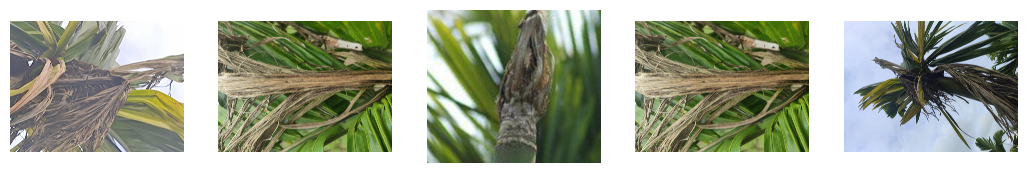

healthy_foot images:


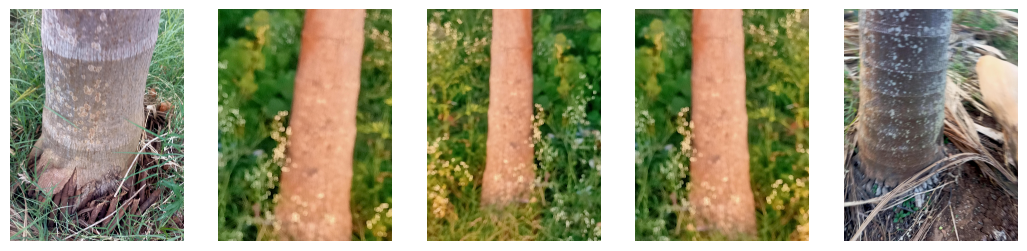

Healthy_Leaf images:


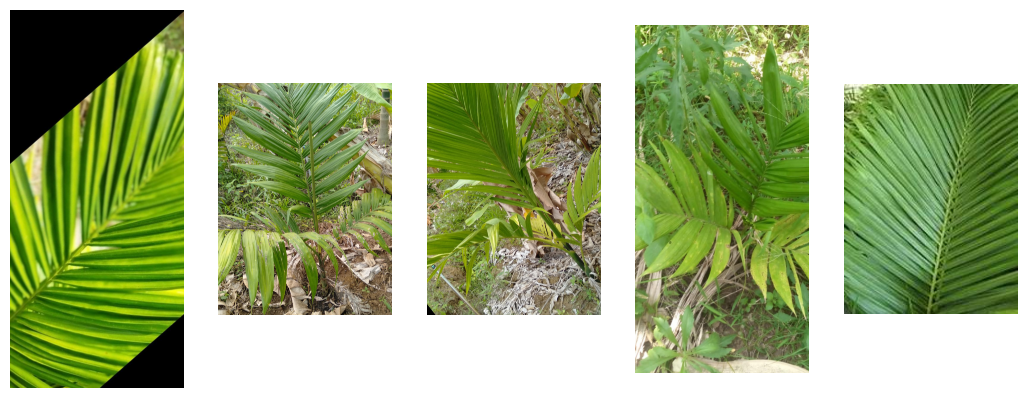

Healthy_Nut images:


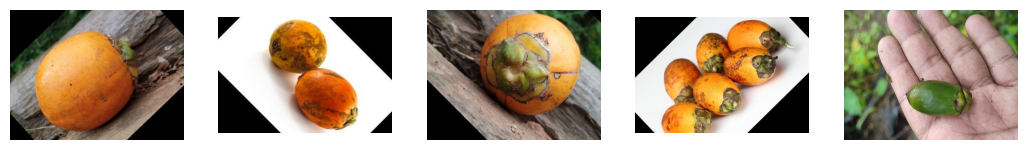

Healthy_Trunk images:


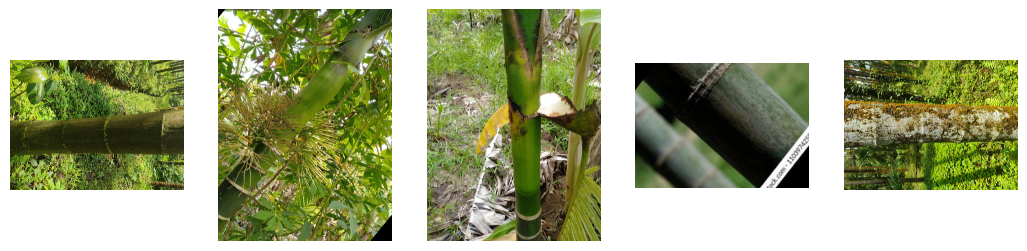

Mahali_Koleroga images:


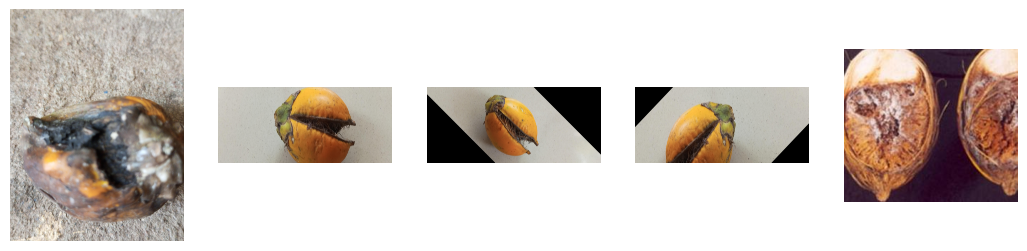

stem cracking images:


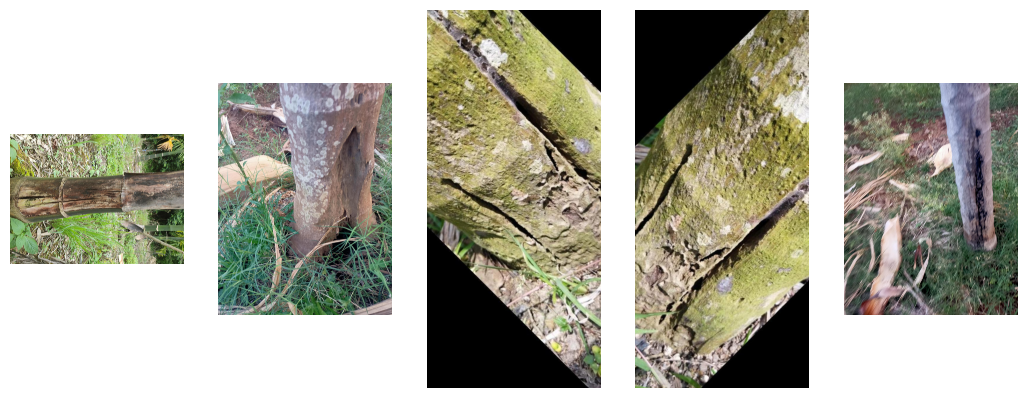

Stem_bleeding images:


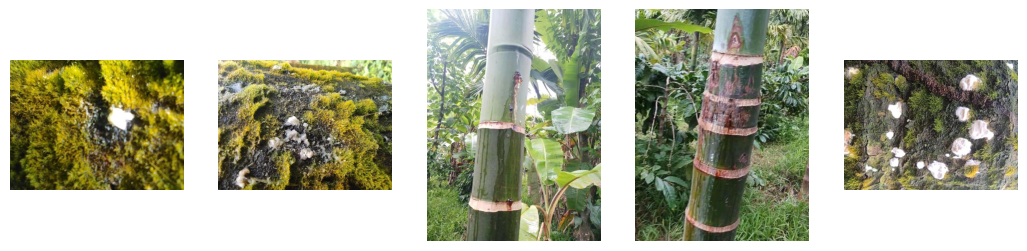

yellow leaf disease images:


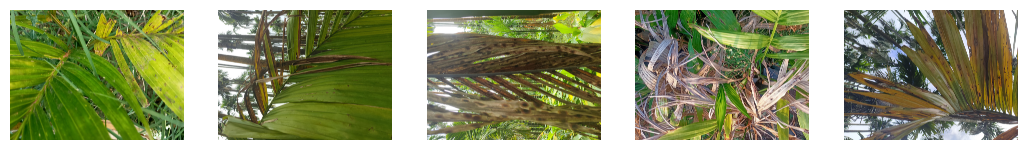

In [4]:

import matplotlib.pyplot as plt

rows, cols = (1, 5)


for category in os.listdir(train_path):
    print(f'{category} images:')
    category_path = os.path.join(train_path, category)
    
    fig = plt.figure(figsize=(13, 8))
    for i in range(rows * cols):
        fig.add_subplot(rows, cols, i + 1)
        
        # List image files in the specific category's directory
        image_files = os.listdir(category_path)
        if not image_files:
            continue
        
        # Select a random image file from the list
        random_image_id = np.random.choice(image_files)
        image = cv.imread(os.path.join(category_path, random_image_id))
        
        plt.imshow(image[:, :, ::-1])  # Convert BGR to RGB
        #plt.title(random_image_id)
        plt.axis('off')
    
    plt.show()


In [5]:
from tqdm import tqdm
class_names = ['stem cracking', 'Stem_bleeding', 'Healthy_Leaf', 'yellow leaf disease', 'healthy_foot', 'Healthy_Trunk', 'Mahali_Koleroga', 'bud borer', 'Healthy_Nut']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

In [6]:
def load_data():
    
    
    datasets = ['C:/Users/amitg/Portfolio_Projects/Areca_Nut_Disease_Prediction/Arecanut_dataset/train', 'C:/Users/amitg/Portfolio_Projects/Areca_Nut_Disease_Prediction/Arecanut_dataset/test']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                #image = cv2.cvtColor(image, cv2.COLOR_RGB2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [7]:
(x_train, y_train), (x_test, y_test) = load_data()

Loading C:/Users/amitg/Portfolio_Projects/Areca_Nut_Disease_Prediction/Arecanut_dataset/train


100%|██████████████████████████████████████████████████████████████████████████████| 1477/1477 [04:01<00:00,  6.11it/s]


Loading C:/Users/amitg/Portfolio_Projects/Areca_Nut_Disease_Prediction/Arecanut_dataset/test


100%|████████████████████████████████████████████████████████████████████████████████| 370/370 [00:52<00:00,  7.09it/s]


In [8]:
batch_size = 64  
epochs = 19
data_augmentation = False
num_classes = 10

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = False

n = 3

version = 1

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

In [9]:
print(model_type)

ResNet20v1


In [10]:
input_shape = x_train.shape[1:]
print(input_shape)

(150, 150, 3)


In [11]:
# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [12]:
# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

x_train shape: (8847, 150, 150, 3)
8847 train samples
2216 test samples
y_train shape: (8847,)


In [13]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

<h4>Learning Rate schedule</h4>

In [14]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


<h4>ResNet Layers</h4>

In [15]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


In [16]:
def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model



In [17]:
if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
print(model_type)
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'IntelImageClass_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]


Learning rate:  0.001
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 150, 150, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 150, 150, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                       

 activation_7 (Activation)      (None, 75, 75, 32)   0           ['batch_normalization_7[0][0]']  
                                                                                                  
 conv2d_8 (Conv2D)              (None, 75, 75, 32)   9248        ['activation_7[0][0]']           
                                                                                                  
 conv2d_9 (Conv2D)              (None, 75, 75, 32)   544         ['activation_6[0][0]']           
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 75, 75, 32)  128         ['conv2d_8[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 add_3 (Add)                    (None, 75, 75, 32)   0           ['conv2d_9[0][0]',               
          

                                                                                                  
 conv2d_19 (Conv2D)             (None, 38, 38, 64)   36928       ['activation_16[0][0]']          
                                                                                                  
 batch_normalization_17 (BatchN  (None, 38, 38, 64)  256         ['conv2d_19[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_17 (Activation)     (None, 38, 38, 64)   0           ['batch_normalization_17[0][0]'] 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 38, 38, 64)   36928       ['activation_17[0][0]']          
                                                                                                  
 batch_nor

In [18]:
# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

Not using data augmentation.
Learning rate:  0.001
Epoch 1/19
139/139 [==============================] - 2065s 15s/step - loss: 1.0123 - accuracy: 0.7275 - val_loss: 1.3488 - val_accuracy: 0.5812 - lr: 0.0010
Learning rate:  0.001
Epoch 2/19
139/139 [==============================] - 1423s 10s/step - loss: 0.5690 - accuracy: 0.8544 - val_loss: 0.9051 - val_accuracy: 0.7617 - lr: 0.0010
Learning rate:  0.001
Epoch 3/19
139/139 [==============================] - 1418s 10s/step - loss: 0.4177 - accuracy: 0.9084 - val_loss: 0.4593 - val_accuracy: 0.8899 - lr: 0.0010
Learning rate:  0.001
Epoch 4/19
139/139 [==============================] - 1588s 11s/step - loss: 0.3391 - accuracy: 0.9333 - val_loss: 0.5750 - val_accuracy: 0.8551 - lr: 0.0010
Learning rate:  0.001
Epoch 5/19
139/139 [==============================] - 1858s 13s/step - loss: 0.3278 - accuracy: 0.9409 - val_loss: 0.3432 - val_accuracy: 0.9332 - lr: 0.0010
Learning rate:  0.001
Epoch 6/19
139/139 [=============================

In [19]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
# model.save('my_models')

70/70 [==============================] - 62s 888ms/step - loss: 0.2448 - accuracy: 0.9567
Test loss: 0.24484971165657043
Test accuracy: 0.9566786885261536


1/1 [==============================] - 0s 309ms/step


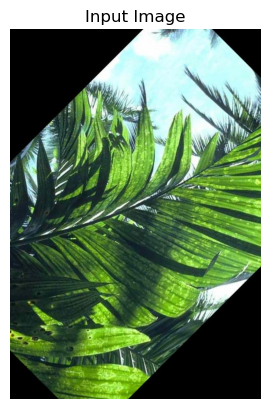

Predicted Disease:  yellow leaf disease
Class Probabilities:  [[4.8719531e-09 1.0431006e-15 1.8956488e-02 9.8098332e-01 1.6441896e-18
  1.6692378e-05 4.1536771e-18 4.2593423e-05 9.4818910e-07 1.3817756e-19]]


In [36]:
image_path = 'C:/Users/amitg/PycharmProjects/Project_work_final/final_testing/yellow leaf disease/yellow leaf disease_original_94.jpg_3ee0a073-182a-46e9-b911-ba7606749785.jpg'
image = cv2.imread(image_path)
image = cv2.resize(image, (150, 150))
image = image.astype('float32') / 255
image = np.expand_dims(image, axis=0)

predictions = model.predict(image)

predicted_class = np.argmax(predictions)

class_names = ['stem cracking', 'Stem_bleeding', 'Healthy_Leaf', 'yellow leaf disease', 'healthy_foot', 'Healthy_Trunk', 'Mahali_Koleroga', 'bud borer', 'Healthy_Nut']
predicted_disease = class_names[predicted_class]

plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
plt.title("Input Image")
plt.axis('off')
plt.show()

highlighted_disease = f"\033[1m{predicted_disease}\033[0m"  # Use ANSI escape codes for highlighting (bold)

print("Predicted Disease: ", highlighted_disease)
print("Class Probabilities: ", predictions)

In [32]:
from sklearn.metrics import confusion_matrix

def calculate_metrics(model, X_train, y_train, X_test, y_test):
    # Predictions on training and test datasets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Convert predicted probabilities to binary predictions (0 or 1)
    y_train_pred_binary = np.argmax(y_train_pred, axis=1)
    y_test_pred_binary = np.argmax(y_test_pred, axis=1)
    y_train_binary = np.argmax(y_train, axis=1)
    y_test_binary = np.argmax(y_test, axis=1)
    train_confusion_matrix = confusion_matrix(y_train_binary, y_train_pred_binary)
    test_confusion_matrix = confusion_matrix(y_test_binary, y_test_pred_binary)



    # Extract TP, TN, FP, FN values from confusion matrices
    train_tp = train_confusion_matrix[1, 1]
    train_tn = train_confusion_matrix[0, 0]
    train_fp = train_confusion_matrix[0, 1]
    train_fn = train_confusion_matrix[1, 0]

    test_tp = test_confusion_matrix[1, 1]
    test_tn = test_confusion_matrix[0, 0]
    test_fp = test_confusion_matrix[0, 1]
    test_fn = test_confusion_matrix[1, 0]

    # Calculate ratios
    train_false_positive_rate = train_fp / (train_fp + train_tn)
    train_false_negative_rate = train_fn / (train_fn + train_tp)
    train_true_positive_rate = train_tp / (train_tp + train_fn)
    train_true_negative_rate = train_tn / (train_tn + train_fp)

    test_false_positive_rate = test_fp / (test_fp + test_tn)
    test_false_negative_rate = test_fn / (test_fn + test_tp)
    test_true_positive_rate = test_tp / (test_tp + test_fn)
    test_true_negative_rate = test_tn / (test_tn + test_fp)

    return {
        "Train False Positive Rate": train_false_positive_rate,
        "Train False Negative Rate": train_false_negative_rate,
        "Train True Positive Rate": train_true_positive_rate,
        "Train True Negative Rate": train_true_negative_rate,
        "Test False Positive Rate": test_false_positive_rate,
        "Test False Negative Rate": test_false_negative_rate,
        "Test True Positive Rate": test_true_positive_rate,
        "Test True Negative Rate": test_true_negative_rate,
    }

# Example usage:
metrics = calculate_metrics(model, x_train, y_train, x_test, y_test)
print(metrics)

70/70 [==============================] - 106s 2s/step
{'Train False Positive Rate': 0.012024048096192385, 'Train False Negative Rate': 0.0, 'Train True Positive Rate': 1.0, 'Train True Negative Rate': 0.9879759519038076, 'Test False Positive Rate': 0.03333333333333333, 'Test False Negative Rate': 0.0, 'Test True Positive Rate': 1.0, 'Test True Negative Rate': 0.9666666666666667}


In [33]:
import joblib

# Assuming your trained model is stored in a variable named 'model'
joblib.dump(model, 'areca_model.pkl')

['areca_model.pkl']

In [34]:
model.save('areca_model_1')

INFO:tensorflow:Assets written to: areca_model_1\assets


INFO:tensorflow:Assets written to: areca_model_1\assets
